Multiclass Classification
In the last notebook, we looked at binary classification. This works well when the data observations belong to one of two classes or categories, such as "True" or "False". When the data can be categorized into more than two classes, you must use a multiclass classification algorithm.

Multiclass classification can be thought of as a combination of multiple binary classifiers. There are two ways in which you approach the problem:

One vs Rest (OVR), in which a classifier is created for each possible class value, with a positive outcome for cases where the prediction is this class, and negative predictions for cases where the prediction is any other class. A classification problem with four possible shape classes (square, circle, triangle, hexagon) would require four classifiers that predict:

square or not

circle or not

triangle or not

hexagon or not

One vs One (OVO), in which a classifier for each possible pair of classes is created. The classification problem with four shape classes would require the following binary classifiers:

square or circle

square or triangle

square or hexagon

circle or triangle

circle or hexagon

triangle or hexagon

In both approaches, the overall model that combines the classifiers generates a vector of predictions in which the probabilities generated from the individual binary classifiers are used to determine which class to predict.

Fortunately, in most machine learning frameworks, including scikit-learn, implementing a multiclass classification model is not significantly more complex than binary classification - and in most cases, the estimators used for binary classification implicitly support multiclass classification by abstracting an OVR algorithm, an OVO algorithm, or by allowing a choice of either.
Explore the data
Let's start by examining a dataset that contains observations of multiple classes. We'll use a dataset that contains observations of three different species of penguin.

Citation: The penguins dataset used in the this exercise is a subset of data collected and made available by https://www.uaf.edu/cfos/people/faculty/detail/kristen-gorman.php and the https://pal.lternet.edu/ , a member of the https://lternet.edu/

In [1]:
import pandas as pd

# load the training dataset
!wget https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/Data/ml-basics/penguins.csv
penguins = pd.read_csv('penguins.csv')

# Display a random sample of 10 observations
sample = penguins.sample(10)
sample

--2023-04-05 07:03:10--  https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/Data/ml-basics/penguins.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7086 (6.9K) [text/plain]
Saving to: ‘penguins.csv’

penguins.csv        100%[===================>]   6.92K  --.-KB/s    in 0s      

2023-04-05 07:03:10 (69.2 MB/s) - ‘penguins.csv’ saved [7086/7086]



,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species
99,43.2,18.5,192.0,4100.0,0
156,47.6,14.5,215.0,5400.0,1
312,47.6,18.3,195.0,3850.0,2
329,50.7,19.7,203.0,4050.0,2
14,34.6,21.1,198.0,4400.0,0
332,45.2,16.6,191.0,3250.0,2
137,40.2,20.1,200.0,3975.0,0
28,37.9,18.6,172.0,3150.0,0
279,45.4,18.7,188.0,3525.0,2
258,41.7,14.7,210.0,4700.0,1


The dataset contains the following columns:

CulmenLength: The length in mm of the penguin's culmen (bill).

CulmenDepth: The depth in mm of the penguin's culmen.

FlipperLength: The length in mm of the penguin's flipper.

BodyMass: The body mass of the penguin in grams.

Species: An integer value that represents the species of the penguin.

The Species column is the label we want to train a model to predict. 
The dataset includes three possible species, which are encoded as 0, 1, and 2. The actual species names are revealed by the code below:

In [2]:
penguin_classes = ['Adelie', 'Gentoo', 'Chinstrap']
print(sample.columns[0:5].values, 'SpeciesName')
for index, row in penguins.sample(10).iterrows():
    print('[',row[0], row[1], row[2], row[3], int(row[4]),']',penguin_classes[int(row[4])])

['CulmenLength' 'CulmenDepth' 'FlipperLength' 'BodyMass' 'Species'] SpeciesName
[ 35.3 18.9 187.0 3800.0 0 ] Adelie
[ 39.6 17.7 186.0 3500.0 0 ] Adelie
[ 49.5 19.0 200.0 3800.0 2 ] Chinstrap
[ 47.6 14.5 215.0 5400.0 1 ] Gentoo
[ 51.0 18.8 203.0 4100.0 2 ] Chinstrap
[ 45.5 13.9 210.0 4200.0 1 ] Gentoo
[ 48.4 14.6 213.0 5850.0 1 ] Gentoo
[ 38.8 20.0 190.0 3950.0 0 ] Adelie
[ 46.8 15.4 215.0 5150.0 1 ] Gentoo
[ 49.8 16.8 230.0 5700.0 1 ] Gentoo


Now that we know what the features and labels in the data represent, let's explore the dataset. First, let's see if there are any missing (null) values.



In [3]:
# Count the number of null values for each column
penguins.isnull().sum()

CulmenLength     2
CulmenDepth      2
FlipperLength    2
BodyMass         2
Species          0
dtype: int64


It looks like there are some missing feature values, but no missing labels. Let's dig a little deeper and see the rows that contain nulls.

In [4]:
# Show rows containing nulls
penguins[penguins.isnull().any(axis=1)]

,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species
3,NaN,NaN,NaN,NaN,0
271,NaN,NaN,NaN,NaN,1


There are two rows that contain no feature values at all (NaN stands for "not a number"), so these won't be useful in training a model. Let's discard them from the dataset.

In [5]:
# Drop rows containing NaN values
penguins=penguins.dropna()
#Confirm there are now no nulls
penguins.isnull().sum()


CulmenLength     0
CulmenDepth      0
FlipperLength    0
BodyMass         0
Species          0
dtype: int64


Now that we've dealt with the missing values, let's explore how the features relate to the label by creating some box charts.



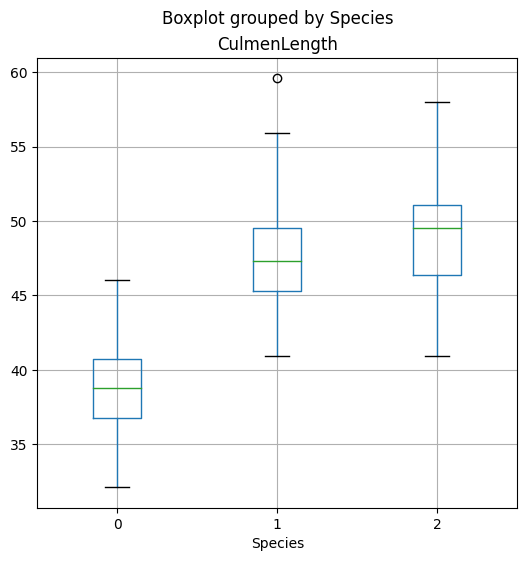

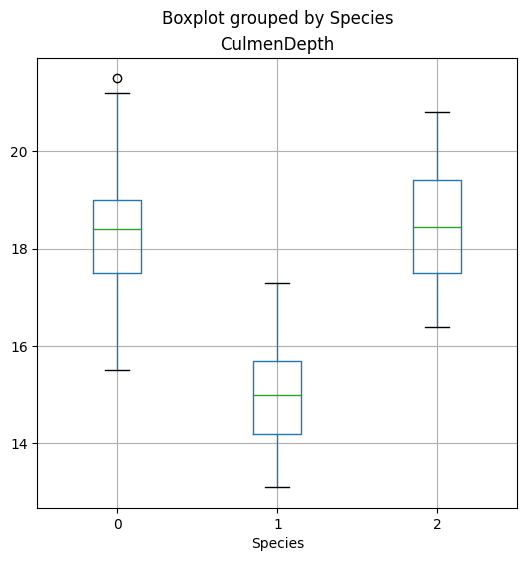

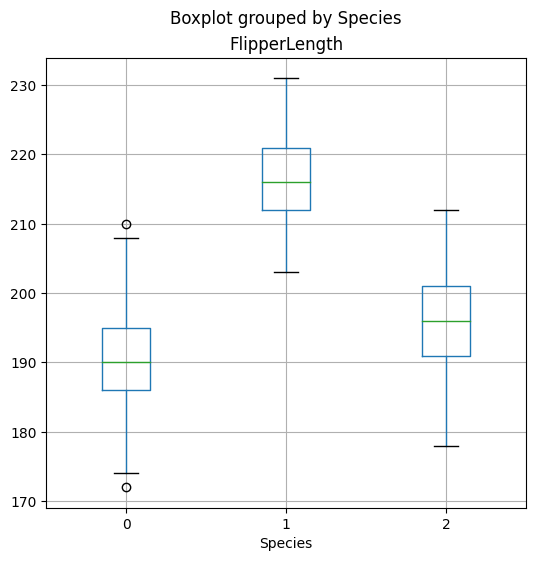

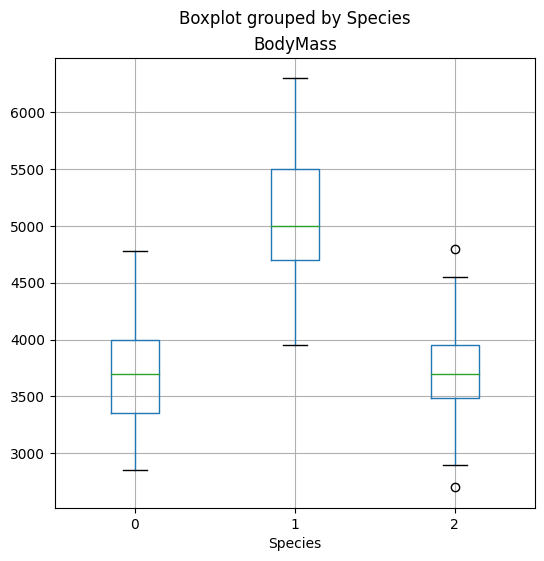

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline

penguin_features = ['CulmenLength','CulmenDepth','FlipperLength','BodyMass']
penguin_label = 'Species'
for col in penguin_features:
    penguins.boxplot(column=col, by=penguin_label, figsize=(6,6))
    plt.title(col)
plt.show()

From the box plots, it looks like species 0 and 2 (Adelie and Chinstrap) have similar data profiles for culmen depth, flipper length, and body mass, but Chinstraps tend to have longer culmens. Species 1 (Gentoo) tends to have fairly clearly differentiated features from the others; which should help us train a good classification model.

Prepare the data

Just as for binary classification, before training the model, we need to separate the features and label, and then split the data into subsets for training and validation. We'll also apply a stratification technique when splitting the data to maintain the proportion of each label value in the training and validation datasets.



In [7]:
from sklearn.model_selection import train_test_split

# Separate features and labels
penguins_X, penguins_y = penguins[penguin_features].values, penguins[penguin_label].values

# Split data 70%-30% into training set and test set
x_penguin_train, x_penguin_test, y_penguin_train, y_penguin_test = train_test_split(penguins_X, penguins_y,
                                                                                    test_size=0.30,
                                                                                    random_state=0,
                                                                                    stratify=penguins_y)

print ('Training Set: %d, Test Set: %d \n' % (x_penguin_train.shape[0], x_penguin_test.shape[0]))

Training Set: 239, Test Set: 103 




Train and evaluate a multiclass classifier
Now that we have a set of training features and corresponding training labels, we can fit a multiclass classification algorithm to the data to create a model. Most scikit-learn classification algorithms inherently support multiclass classification. We'll try a logistic regression algorithm.

In [8]:
from sklearn.linear_model import LogisticRegression

# Set regularization rate
reg = 0.1

# train a logistic regression model on the training set
multi_model = LogisticRegression(C=1/reg, solver='lbfgs', multi_class='auto', max_iter=10000).fit(x_penguin_train, y_penguin_train)
print (multi_model)

LogisticRegression(C=10.0, max_iter=10000)



Now we can use the trained model to predict the labels for the test features, and compare the predicted labels to the actual labels:

In [9]:
penguin_predictions = multi_model.predict(x_penguin_test)
print('Predicted labels: ', penguin_predictions[:15])
print('Actual labels   : ' ,y_penguin_test[:15])

Predicted labels:  [0 1 0 2 2 1 1 1 0 2 2 1 2 1 2]
Actual labels   :  [0 1 2 2 2 1 1 1 0 2 2 1 2 1 2]



Let's look at a classification report.

In [10]:
from sklearn. metrics import classification_report

print(classification_report(y_penguin_test, penguin_predictions))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97        45
           1       1.00      1.00      1.00        37
           2       0.95      0.90      0.93        21

    accuracy                           0.97       103
   macro avg       0.97      0.96      0.96       103
weighted avg       0.97      0.97      0.97       103




As with binary classification, the report includes precision and recall metrics for each class. However, while with binary classification we could focus on the scores for the positive class; in this case, there are multiple classes so we need to look at an overall metric (either the macro or weighted average) to get a sense of how well the model performs across all three classes.

You can get the overall metrics separately from the report using the scikit-learn metrics score classes, but with multiclass results you must specify which average metric you want to use for precision and recall.

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

print("Overall Accuracy:",accuracy_score(y_penguin_test, penguin_predictions))
print("Overall Precision:",precision_score(y_penguin_test, penguin_predictions, average='macro'))
print("Overall Recall:",recall_score(y_penguin_test, penguin_predictions, average='macro'))

Overall Accuracy: 0.970873786407767
Overall Precision: 0.9688405797101449
Overall Recall: 0.9608465608465608



Now let's look at the confusion matrix for our model:



In [12]:
from sklearn.metrics import confusion_matrix

# Print the confusion matrix
mcm = confusion_matrix(y_penguin_test, penguin_predictions)
print(mcm)

[[44  0  1]
 [ 0 37  0]
 [ 2  0 19]]



The confusion matrix shows the intersection of predicted and actual label values for each class - in simple terms, the diagonal intersections from top-left to bottom-right indicate the number of correct predictions.

When dealing with multiple classes, it's generally more intuitive to visualize this as a heat map, like this:

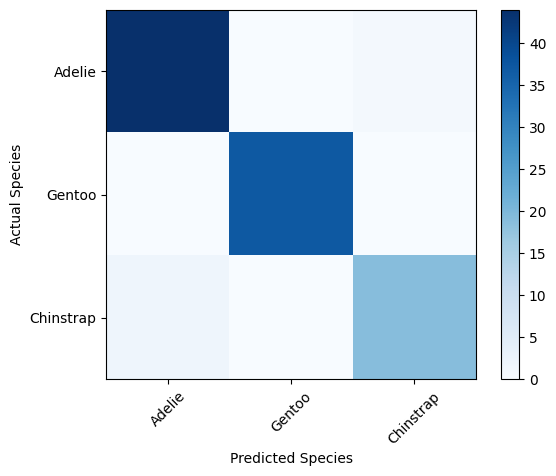

In [13]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(mcm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(penguin_classes))
plt.xticks(tick_marks, penguin_classes, rotation=45)
plt.yticks(tick_marks, penguin_classes)
plt.xlabel("Predicted Species")
plt.ylabel("Actual Species")
plt.show()


The darker squares in the confusion matrix plot indicate high numbers of cases, and you can hopefully see a diagonal line of darker squares indicating cases where the predicted and actual label are the same.

In the case of a multiclass classification model, a single ROC curve showing true positive rate vs false positive rate is not possible. However, you can use the rates for each class in a One vs Rest (OVR) comparison to create a ROC chart for each class.



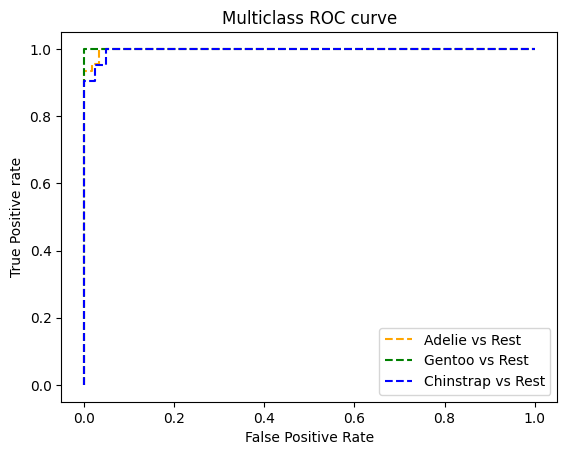

In [14]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Get class probability scores
penguin_prob = multi_model.predict_proba(x_penguin_test)

# Get ROC metrics for each class
fpr = {}
tpr = {}
thresh ={}
for i in range(len(penguin_classes)):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_penguin_test, penguin_prob[:,i], pos_label=i)
    
# Plot the ROC chart
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label=penguin_classes[0] + ' vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label=penguin_classes[1] + ' vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label=penguin_classes[2] + ' vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show()


To quantify the ROC performance, you can calculate an aggregate area under the curve score that is averaged across all of the OVR curves.

In [15]:
auc = roc_auc_score(y_penguin_test,penguin_prob, multi_class='ovr')
print('Average AUC:', auc)

Average AUC: 0.9981999902100828


Preprocess data in a pipeline

Again, just like with binary classification, you can use a pipeline to apply preprocessing steps to the data before fitting it to an algorithm to train a model. Let's see if we can improve the penguin predictor by scaling the numeric features in a transformation steps before training. We'll also try a different algorithm (a support vector machine), just to show that we can!

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

# Define preprocessing for numeric columns (scale them)
feature_columns = [0,1,2,3]
feature_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
    ])

# Create preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('preprocess', feature_transformer, feature_columns)])

# Create training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', SVC(probability=True))])


# fit the pipeline to train a linear regression model on the training set
multi_model = pipeline.fit(x_penguin_train, y_penguin_train)
print (multi_model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('preprocess',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3])])),
                ('regressor', SVC(probability=True))])



Now we can evaluate the new model.

Overall Accuracy: 0.9805825242718447
Overall Precision: 0.9767195767195768
Overall Recall: 0.9767195767195768
Average AUC: 0.9990361381446328


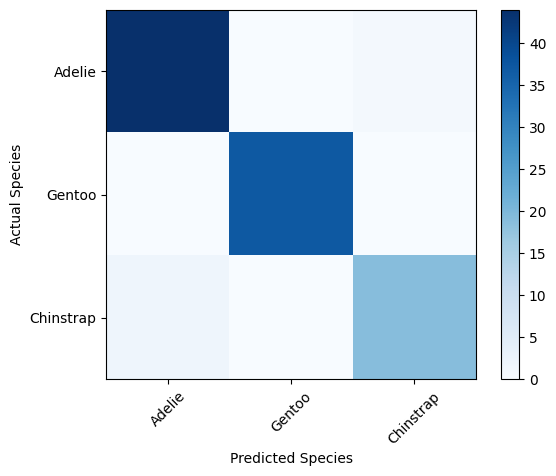

In [17]:
# Get predictions from test data
penguin_predictions = multi_model.predict(x_penguin_test)
penguin_prob = multi_model.predict_proba(x_penguin_test)

# Overall metrics
print("Overall Accuracy:",accuracy_score(y_penguin_test, penguin_predictions))
print("Overall Precision:",precision_score(y_penguin_test, penguin_predictions, average='macro'))
print("Overall Recall:",recall_score(y_penguin_test, penguin_predictions, average='macro'))
print('Average AUC:', roc_auc_score(y_penguin_test,penguin_prob, multi_class='ovr'))

# Confusion matrix
plt.imshow(mcm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(penguin_classes))
plt.xticks(tick_marks, penguin_classes, rotation=45)
plt.yticks(tick_marks, penguin_classes)
plt.xlabel("Predicted Species")
plt.ylabel("Actual Species")
plt.show()

Use the model with new data observations
Now let's save our trained model so we can use it again later.



In [18]:
import joblib

# Save the model as a pickle file
filename = './penguin_model.pkl'
joblib.dump(multi_model, filename)

['./penguin_model.pkl']

OK, so now we have a trained model. Let's use it to predict the class of a new penguin observation:



In [19]:
# Load the model from the file
multi_model = joblib.load(filename)

# The model accepts an array of feature arrays (so you can predict the classes of multiple penguin observations in a single call)
# We'll create an array with a single array of features, representing one penguin
x_new = np.array([[50.4,15.3,224,5550]])
print ('New sample: {}'.format(x_new[0]))

# The model returns an array of predictions - one for each set of features submitted
# In our case, we only submitted one penguin, so our prediction is the first one in the resulting array.
penguin_pred = multi_model.predict(x_new)[0]
print('Predicted class is', penguin_classes[penguin_pred])

New sample: [  50.4   15.3  224.  5550. ]
Predicted class is Gentoo


You can also submit a batch of penguin observations to the model, and get back a prediction for each one.



In [20]:
# This time our input is an array of two feature arrays
x_new = np.array([[49.5,18.4,195, 3600],
         [38.2,20.1,190,3900]])
print ('New samples:\n{}'.format(x_new))

# Call the web service, passing the input data
predictions = multi_model.predict(x_new)

# Get the predicted classes.
for prediction in predictions:
    print(prediction, '(' + penguin_classes[prediction] +')')

New samples:
[[  49.5   18.4  195.  3600. ]
 [  38.2   20.1  190.  3900. ]]
2 (Chinstrap)
0 (Adelie)



Summary

Classification is one of the most common forms of machine learning, and by following the basic principles we've discussed in this notebook you should be able to train and evaluate classification models with scikit-learn. It's worth spending some time investigating classification algorithms in more depth, and a good starting point is the Scikit-Learn documentation.